In [1]:
import sys; sys.path.append('..')
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from cifar10_models.clip_models import ClipViTB32
from src.data_utils import get_dataset, cifar10_label_names
from src.simple_utils import load_pickle
from os.path import join as pjoin
from collections import Counter


In [2]:
%%capture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_dir = "../clip_checkpoints/"
checkpoint_dir = "checkpoints13084"
checkpoint_name = "last.ckpt"
path = pjoin(model_dir, checkpoint_dir, checkpoint_name)

checkpoint = torch.load(path)
state_dict = checkpoint['state_dict']
state_dict = {k.split('.', 1)[1]: v for k, v in state_dict.items()}

model = ClipViTB32()
model.load_state_dict(state_dict)
model.to(device)
model.eval()


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import cifar10_label_names, get_dataset
from os.path import join

print("loading data ...")
grouped = load_pickle('../processed/group.pkl')
scores = load_pickle('../processed/scores/scores.pkl')
print("done")


# Test sets in this data
test_sets = ["CIFAR10_test", "CIFAR10v2_test", "CINIC10_test"]
# name of training dataset
train_set = "CIFAR10_train"


print("loading dataset ...")
dataset = {}
labels = {}

for name in test_sets: 
    dataset[name] = get_dataset('../data', dset = name, transform = model.preprocess)
    labels[name] = np.array(dataset[name].targets)
print("done")



loading data ...
done
loading dataset ...
Files already downloaded and verified
done


In [7]:
classes = cifar10_label_names

# Dataset name
name=test_sets[2]
arch = "Resnet18"

# Plots params 
fmts = {
    "Resnet18": "bo",
    "Densenet121": "ro",
    "Resnet18-pretrained": "c^",
    "Densenet121-pretrained": "m^",
    "ClipViTB32": "go",
}

alpha = 0.5
markersize = 12
    
# CINIC Neg stats


# def aggregate_scores(dct):
#     x = dct["x"]
#     return dct["x"], np.mean(dct["points"], axis = 0)
   
def aggregate_scores(dct, idx): 
    x = dct["x"]
    return dct["x"], np.mean(dct["points"][idx], axis = 0)


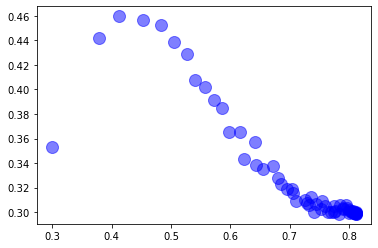

In [36]:
n = 10000 # Vary n to vary the neg correlation behaviour. Overall n = 90000 gives accuracy on line and n = 10000 gives neg correlation. 

idx = scores[name]["idx"][:n].astype(int)

dct = grouped[name][arch]

x, y = aggregate_scores(dct, idx)

plt.plot(x, y, fmts[arch], alpha=alpha, markersize=markersize, label=arch)

In [37]:
dataloader = DataLoader(Subset(dataset[name], idx), batch_size=512, shuffle=False)


In [38]:
acc = []

for i, batch in enumerate(dataloader):
    if i % 100 ==  0:
        print(f'batch_idx: {i}')
        
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)
        acc.append((preds == labels))
        
acc = torch.cat(acc)
acc = acc.cpu().numpy()

batch_idx: 0


In [40]:
idx_keep = np.where(acc == 1)[0]

idx_corr = idx[idx_keep]

In [53]:
# idx = np.array(idx)
labels = np.array(dataset[name].targets)
labels = labels[idx_bal]

c = Counter(labels)

print(c)

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 100})


In [67]:

def min_class_size(classes, idx):
    classes = np.array(classes)
    cnt = Counter(classes[idx])
    for c, val in cnt.most_common():
        print(f"{c}: {100 * val / len(idx):,.2f}%")
    
    min_class = np.inf

    for c in range(10):
        if c not in cnt:
            return 0
        
        min_class = min(min_class, cnt[c])
    
    return min_class

min_class_size(classes, idx)

5: 15.30%
7: 13.47%
8: 11.74%
4: 11.00%
1: 10.57%
9: 9.27%
6: 9.18%
2: 7.95%
3: 7.38%
0: 4.14%


414

In [20]:
def extract_class_bal_dset(classes, idx, min_class, num_classes=10):
    # classes = np.array(classes)[idx]
    class_idxs = []
    for k in range(num_classes):
        class_idx = np.where(classes == k)[0]
        class_idxs.append(idx[class_idx[:min_class]])

    idx_bal = np.concatenate(class_idxs)
    return idx_bal
    

In [48]:
idx_bal = extract_class_bal_dset(labels, idx_corr, 100)

In [49]:
dataloader = DataLoader(Subset(dataset[name], idx_bal), batch_size=512, shuffle=False)


In [50]:
acc = []

for i, batch in enumerate(dataloader):
    if i % 100 ==  0:
        print(f'batch_idx: {i}')
        
    imgs, labels = batch
    imgs, labels = imgs.to(device), labels.to(device)
    
    with torch.no_grad():
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1)
        acc.append((preds == labels))
        
acc = torch.cat(acc)
acc = acc.cpu().numpy()

np.mean(acc)

batch_idx: 0


1.0

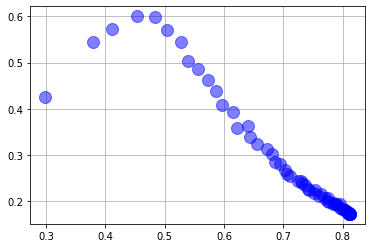

In [65]:
# n = 10000 # Vary n to vary the neg correlation behaviour. Overall n = 90000 gives accuracy on line and n = 10000 gives neg correlation. 

# idx = scores[name]["idx"][:n].astype(int)

# dct = grouped[name][arch]

x, y = aggregate_scores(dct, idx_bal)
plt.grid()
plt.plot(x, y, fmts[arch], alpha=alpha, markersize=markersize, label=arch)

In [61]:
# len(idx_bal)
idx = idx_bal
data_x = [] 
data_y = []

for i in idx: 
    x,y = dataset[name][i]
    data_x.append(x.numpy())
    data_y.append(y)    

In [62]:
np.savez("CINIC_neg.npz", idx_orig = idx, data_x = np.array(data_x), data_y = np.array(data_y))

array([[[0.3975015 , 0.3975015 , 0.3975015 , ..., 0.42669836,
         0.42669836, 0.42669836],
        [0.3975015 , 0.3975015 , 0.3975015 , ..., 0.42669836,
         0.42669836, 0.42669836],
        [0.3975015 , 0.3975015 , 0.3975015 , ..., 0.42669836,
         0.42669836, 0.42669836],
        ...,
        [0.44129676, 0.44129676, 0.44129676, ..., 0.49969047,
         0.49969047, 0.49969047],
        [0.44129676, 0.44129676, 0.44129676, ..., 0.49969047,
         0.49969047, 0.49969047],
        [0.44129676, 0.44129676, 0.44129676, ..., 0.49969047,
         0.49969047, 0.49969047]],

       [[1.2644643 , 1.2644643 , 1.2644643 , ..., 1.2794721 ,
         1.2794721 , 1.2794721 ],
        [1.2644643 , 1.2644643 , 1.2644643 , ..., 1.2794721 ,
         1.2794721 , 1.2794721 ],
        [1.2644643 , 1.2644643 , 1.2644643 , ..., 1.2794721 ,
         1.2794721 , 1.2794721 ],
        ...,
        [1.1744177 , 1.1744177 , 1.1744177 , ..., 1.3695186 ,
         1.3695186 , 1.3695186 ],
        [1.1